In [157]:
# plaidml Keras default template code
import numpy as np
import pandas as pd
import os
import time
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras

# MNIST KERAS Basics 99.7%
Complete CV DL workflow and visualisation

In [52]:
# standard ds imports
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import seaborn as sns
%matplotlib inline

In [53]:
# standard sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [54]:
import itertools

In [162]:
# basic keras sequential model and image imports
# use for plaidml acceleration
from keras.utils.np_utils import to_categorical # for one hot encoding
from keras.models import Sequential # model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool1D, MaxPool2D # layers
from keras.optimizers import RMSprop # learning optimizer
from keras.preprocessing.image import ImageDataGenerator # generator function for loading images
from keras.callbacks import ReduceLROnPlateau # learning rate callback for early stopping

In [159]:
# imports from tf.keras
## not supported by plaidml
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import Model as tf_Model
from tensorflow.keras import Sequential as tf_Sequential
from tensorflow.keras import layers as tf_layers

2.0.0


In [56]:
# set visualisation settings
sns.set(style='white', context='notebook')
sns.set_palette(palette='Paired', desat=0.8)
# set figure sizes
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11,7

## Load Data

In [57]:
# load train and test data
# reference Data folder
train_path = '../Data/Digits/digit-recognizer/train.csv'
test_path = '../Data/Digits/digit-recognizer/test.csv'

In [58]:
# load dataframes
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [59]:
# basic training data inspection
print(train.columns)
print(len(train.columns))
print(train.info())

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
785
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


In [60]:
# check for null values in data
for x in (train, test):
    print(x.isnull().any().describe(), '\n')

count       785
unique        1
top       False
freq        785
dtype: object 

count       784
unique        1
top       False
freq        784
dtype: object 



In [61]:
# split training data into features and labels
y_train = train['label'].copy()

In [62]:
# split x_train from training data and remove target label column
x_train = train.drop('label', axis=1).copy()

In [63]:
# clear original dataframe from memory
del train

In [64]:
# print data shape
print('Training data shape:{}'.format(x_train.shape))
print('Target label shape :{}'.format(y_train.shape))
print('Test data shape:{}'.format(test.shape))

Training data shape:(42000, 784)
Target label shape :(42000,)
Test data shape:(28000, 784)


In [65]:
# observe class distribution
print(y_train.value_counts())

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


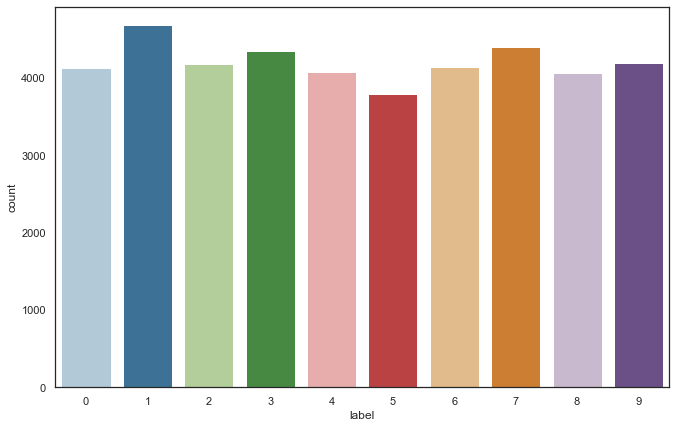

In [25]:
# create bar chart of label distribution
g = sns.countplot(y_train)

## Image Transformation
Visualise images by converting DF values into np floats and plotting

In [66]:
# convert training data into np floats
x_train = x_train[:].values.astype(np.float)

In [67]:
# convert labels into np floats
y_train = y_train[:].values.astype(np.float)

In [68]:
# convert test data into np floats
x_test = test.values.astype(np.float)

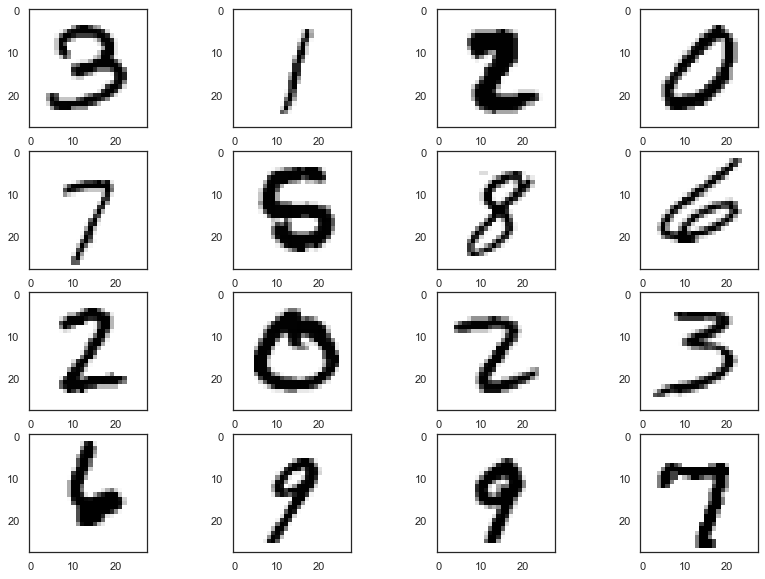

In [107]:
# plot sample training data
x, y = 4, 4
plt.figure(figsize=(14,10))
for i in range(16):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i+14].reshape((28,28)),interpolation='nearest', cmap='gist_yarg')
plt.show()

### Normalize images
Reduce images from RBG 0,255 to Black 0,1

In [108]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [113]:
print(x_train.shape) # returns tuple of 0,1 indexes
print(x_test.shape)
print(x_train.shape[0]) # value for reshaping training data into matrix

(42000, 784)
(28000, 784)
42000


In [114]:
# reshape original data from format (rows, array) to (rows, x, y, channel)
# use capital X to define matrix format input data for keras and retain x_train for future
X_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
X_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [117]:
print(X_train.shape)
print(X_test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


### Encode labels into OHE

In [137]:
# define number of classes
targets = len((np.unique(y_train)))
print('Number of class labels: {}'.format(targets))

Number of class labels: 10


In [138]:
# convert labels into one hot categorical representation
Y_train = to_categorical(y_train, num_classes=targets)

In [139]:
# compare representations
print(y_train[0])
print(Y_train[0])

1.0
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


### Split training data into train and evaluation sets

In [142]:
# set random seed for reproducibility 
random_seed = 14

In [144]:
# create train test split using 10% for eval
# retain original X_train for further split experiments
# use k_trainX notation for keras model splits
k_trainX, k_valX, k_trainY, k_valY = train_test_split(X_train, Y_train, 
                                                      test_size=0.1,
                                                      random_state=random_seed)

## Model Development

### Standard CNN architecture
Use a simple and proven model design for this dataset to understand the basics of image classification.

Taken from [https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook] and [https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457] adapted slightly for tf.keras. This model achieves a high baseline score and can be further improved using data augmentation methods for increasing performance. 

These methods are a good starting point for CV based tasks.

// use Keras api for plaidml acceleration


### Model Design
Sequential Model:
    
    - Conv2D [ filters=32, kernel=(5,5) ] [ input_shape = (28,28,1) ]
    - Conv2D [ filters=32, kernel=(5,5) ]
    - MaxPool2D [ pool_size=(2,2) ]
    - Dropout [ 0.2 ]
    
    - Conv2D [ filters=64, kernel=(3,3) ] # double filters, reduce kernel: Downsampling
    - Conv2D [ filters=64, kernel=(3,3) ]
    - MaxPool2D [ pool_size=(2,2), strides=(2,2) ] # stride for final pooling
    - Dropout [ 0.2 ]
    - Flatten # create single vector for dense classifier
    
    - Dense [ 256 ]
    - Dropout [ 0.2 ]
    - Dense [ 10  activation=softmax ] # final classifier, softmax for prediction

In [147]:
# define model parameters for reuse
train_shape = (28,28,1)
num_class = targets # for reference

In [177]:
# create model using tf.keras api
# use K naming for models to allow for futher experiments in this notebook on the same training data
model_k0 = Sequential()

In [178]:
# add first set of convolutions
model_k0.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=train_shape, activation='relu')) # input layer
model_k0.add(Conv2D(32, (5,5), activation='relu'))
model_k0.add(MaxPool2D(pool_size=(2,2)))
model_k0.add(Dropout(0.2))

In [179]:
# add second set of convolutions
# double filter size # reduce kernel size
model_k0.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_k0.add(Conv2D(64, (3,3), activation='relu'))
model_k0.add(MaxPool2D(pool_size=(2,2), strides=(2,2))) # add stride for final pooling
model_k0.add(Dropout(0.2))

In [180]:
# flatten convolutions
model_k0.add(Flatten())

In [181]:
# add dense classifier
model_k0.add(Dense(256, activation='relu'))
model_k0.add(Dropout(0.4))
model_k0.add(Dense(10, activation='softmax'))

In [182]:
### Compile Model Optimizer and Loss function
# adam achieves 99% training, 98% val, suggest slight overfitting
# RMSProp 
model_k0.compile(optimizer=keras.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

In [183]:
# final model design
model_k0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 64)          0         
__________

### First run model training 
establish baseline performance for this simple model design

increase performance in subsequent training experiments with parameter turning and
image data generator


In [173]:
history = model_k0.fit(k_trainX, k_trainY, batch_size=64, epochs=10, 
                       validation_data=(k_valX, k_valY), verbose=1)

Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37760/37800 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9939

INFO:plaidml:Analyzing Ops: 95 of 271 operations complete


37800/37800 [==============================] - 39s 1ms/step - loss: 0.0199 - acc: 0.9939 - val_loss: 0.0374 - val_acc: 0.9900
Epoch 2/10
37800/37800 [==============================] - 27s 719us/step - loss: 0.0195 - acc: 0.9943 - val_loss: 0.0550 - val_acc: 0.9871
Epoch 3/10
37800/37800 [==============================] - 27s 715us/step - loss: 0.0175 - acc: 0.9949 - val_loss: 0.0450 - val_acc: 0.9890
Epoch 4/10
37800/37800 [==============================] - 27s 715us/step - loss: 0.0175 - acc: 0.9950 - val_loss: 0.0412 - val_acc: 0.9914
Epoch 5/10
37800/37800 [==============================] - 27s 715us/step - loss: 0.0164 - acc: 0.9954 - val_loss: 0.0375 - val_acc: 0.9917
Epoch 6/10
37800/37800 [==============================] - 27s 716us/step - loss: 0.0156 - acc: 0.9956 - val_loss: 0.0489 - val_acc: 0.9895
Epoch 7/10
37800/37800 [==============================] - 27s 721us/step - loss: 0.0157 - acc: 0.9956 - val_loss: 0.0595 - val_acc: 0.9886
Epoch 8/10
37800/37800 [================

### Data Augmentation and Reduce on LR
Overfitting slightly as val acc is lower than training acc.

Use image data generator and learning rate plateu to combat overfitting and increase validation accuracy.

Possibly increase train test split and observe results change

In [176]:
# define learning rate callback
# reduce learning rate when accuracy does not improve
# use method from kaggle kernel to observe performance improvement
lr_callback = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5,
                                min_lr=0.00001
)

### Data Augmentation
Apply a set of simple image transform operations to generate data:

    - 10 degree rotation
    - 10% zoom
    - 10% horizontal width shift
    - 10% vertical height shift

In [184]:
# all other params of data generator default to false
# such as mean centering and whitening
# set data generator dict params
datagen = ImageDataGenerator(
    rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1
)

In [185]:
# fit generator to training data
# fit on k_trainX to retain train test split
datagen.fit(k_trainX)

In [191]:
len(k_trainX) // 86

439

In [187]:
k_trainX.shape

(37800, 28, 28, 1)

In [193]:
# repeat model training using generator fit
# use datagen.flow to feed batches in real time during model training
# use the same batch size as kaggle notebook and earlier model for consistency
# use floor division for steps per epoch by batch size
# notebook uses X_train.shape[0] which is == len(X_train)
# add learning rate callback to optimize lr
history = model_k0.fit_generator(
    datagen.flow(k_trainX, k_trainY, batch_size=86),
    validation_data=(k_valX, k_valY),
    steps_per_epoch=len(k_trainX) // 86, epochs=5,
    callbacks=[lr_callback], verbose=1
)

Epoch 1/5
439/439 [==============================] - 33s 75ms/step - loss: 0.1127 - acc: 0.9660 - val_loss: 0.0525 - val_acc: 0.9821
Epoch 2/5
439/439 [==============================] - 30s 69ms/step - loss: 0.0909 - acc: 0.9722 - val_loss: 0.0352 - val_acc: 0.9886
Epoch 3/5
439/439 [==============================] - 30s 69ms/step - loss: 0.0791 - acc: 0.9756 - val_loss: 0.0313 - val_acc: 0.9924
Epoch 4/5
439/439 [==============================] - 30s 69ms/step - loss: 0.0706 - acc: 0.9796 - val_loss: 0.0314 - val_acc: 0.9910
Epoch 5/5
439/439 [==============================] - 31s 70ms/step - loss: 0.0656 - acc: 0.9808 - val_loss: 0.0356 - val_acc: 0.9900


### Results
Validation accuracy > training accuracy, shows that data augmentation helped reduce overfitting and the model is more reliable and higher performing than before. 

Repeat training with more epochs to try to come close to kaggle top percentil of 99.7% accuracy.

In [194]:
# repeat for 15 epochs
history = model_k0.fit_generator(
    datagen.flow(k_trainX, k_trainY, batch_size=86),
    validation_data=(k_valX, k_valY),
    steps_per_epoch=len(k_trainX) // 86, epochs=15,
    callbacks=[lr_callback], verbose=1
)

Epoch 1/15
439/439 [==============================] - 31s 71ms/step - loss: 0.0594 - acc: 0.9831 - val_loss: 0.0333 - val_acc: 0.9919
Epoch 2/15
439/439 [==============================] - 30s 69ms/step - loss: 0.0588 - acc: 0.9833 - val_loss: 0.0433 - val_acc: 0.9898
Epoch 3/15
439/439 [==============================] - 30s 69ms/step - loss: 0.0543 - acc: 0.9841 - val_loss: 0.0390 - val_acc: 0.9898
Epoch 4/15
439/439 [==============================] - 30s 69ms/step - loss: 0.0523 - acc: 0.9852 - val_loss: 0.0477 - val_acc: 0.9867

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/15
439/439 [==============================] - 30s 69ms/step - loss: 0.0405 - acc: 0.9887 - val_loss: 0.0271 - val_acc: 0.9921
Epoch 6/15
439/439 [==============================] - 30s 69ms/step - loss: 0.0378 - acc: 0.9891 - val_loss: 0.0300 - val_acc: 0.9926
Epoch 7/15
439/439 [==============================] - 30s 69ms/step - loss: 0.0381 - acc: 0.9892 - val_loss: 0.0297

## Final Result
#### Val Acc 99.45%, Acc 99.22%